In [1]:
import sqlite3
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost import XGBRegressor

In [2]:
path = 'C:/Users/20212324/DC2/database_final.db'
conn = sqlite3.connect(path)
query_burg = """SELECT * FROM table_name
WHERE "Crime Type" = "Burglary"
"""
query_sun = """SELECT * FROM sunlight"""
query_house = """SELECT * FROM housing_by_lsoa"""
query_unep = """SELECT * FROM montly_unemployement_claimant_count_by_lsoa_barnet"""

df_burglary_all = pd.read_sql(query_burg, conn)
df_sunlight_all = pd.read_sql(query_sun, conn)
df_housing_all = pd.read_sql(query_house, conn)
df_unemployment_all = pd.read_sql(query_unep, conn)
#getting data from database and storing in DF
conn.close()

In [3]:
df_unemployment = df_unemployment_all.rename(columns={'geogcode': 'LSOA code'}) 
df_unemployment['Month'] =  pd.to_datetime(df_unemployment['date'])
df_unemployment_5yr = df_unemployment[(df_unemployment['Month'].dt.year >= 2013) & (df_unemployment['Month'].dt.year <= 2019)]
df_unemployment_5yr = df_unemployment_5yr[df_unemployment_5yr['LSOA code'] != 'Column Total']
df_unemployment_5yr["Unemployment"] = df_unemployment_5yr["value"]
df_unemployment_5yr = df_unemployment_5yr.drop(columns=["date", "index", "value"], axis=1)
#filterig unemployment to 5 year time spand of 2014 to 2019 and renaming columns for compatibility 
#2013 included for time lag

In [4]:

df_bar=df_burglary_all[df_burglary_all['LSOA name'].str.contains('Barnet')].drop(columns=['Reported by', 'Falls within']).dropna()
df_bar['Month'] = pd.to_datetime(df_bar['Month'])
df_bar['Year']= df_bar['Month'].dt.year
df_bar_5yr = df_bar[(df_bar['Month'].dt.year >= 2013) & (df_bar['Month'].dt.year <= 2019)]

#Filtering for Barnet data, 2013 included for time lag

In [5]:
df_sunlight_all['Month'] = pd.to_datetime(df_sunlight_all['Year-Month'])
df_sunlight=df_sunlight_all.drop(columns=["Year-Month", "index"], axis=1)
#Sunlight DF, ensuring compatibility by creating Datime Col


In [6]:
#df_housing = df_housing.drop(columns=["index"], axis=1)
#Housing dataframe
df_housing_clean = df_housing_all[["Proportion of indep", "Proportion small house", "Proportion social", "Proportion rented", "LSOA name",  "LSOA code" ]]

In [7]:
burglaries_per_lsoa_month = df_bar_5yr[df_bar_5yr['Crime type'] == 'Burglary'].groupby(['LSOA code', 'Month']).size()
burglaries_per_lsoa_month = burglaries_per_lsoa_month.reset_index(name='Total Burglaries')
#Getting total burglaries per LSOA on a Monthly basis

In [8]:
temp_merged = burglaries_per_lsoa_month.merge(df_housing_clean, how='left', on=['LSOA code']).dropna() #Merging Berg and Housing
df_merged = temp_merged.merge(df_sunlight, how='left', on=['Month']) #Merging sunlight and (Housing+Burg)
df_merged_2 =  df_merged.merge(df_unemployment_5yr, how='left', on=['Month', 'LSOA code']) #Mergving pervious with unemployment
temp_merged_clean = df_merged_2.drop(columns=['LSOA name']) #Drop unnecessary Cols

In [9]:
lags = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  # Giving Lag value in months
df = temp_merged_clean

for lag in lags:
    column_name_unep = f"Unemployment_PctChange_{lag}m"  # New column name for unemployment
    df[column_name_unep] = df.groupby('LSOA code')['Unemployment'].pct_change(periods=lag) * 100
    df[column_name_unep].replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN

    column_name_burg = f"Total_Burglaries_PctChange_{lag}m"  # New column name for burglaries
    df[column_name_burg] = df.groupby('LSOA code')['Total Burglaries'].pct_change(periods=lag) * 100
    df[column_name_burg].replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace inf values with NaN

df.fillna(0, inplace=True)  # Replace remaining NaN values with zeros


In [10]:
# Create dummy variables for the 'LSOA code' column
dummy_df = pd.get_dummies(temp_merged_clean['LSOA code'], prefix='LSOA')

# Concatenate the dummy variables with the original DF
df_temp_merged_clean_dummies = pd.concat([temp_merged_clean, dummy_df], axis=1)
df_temp_merged_clean_dummies['Month_Int'] = df_temp_merged_clean_dummies['Month'].dt.month #Creating month int col
df_temp_merged_clean_dummies.head()

# Create dummy variables for the 'Month_Intdf_temp_merged_clean_dummies = pd.concat([temp_merged_clean, dummy_df], axis=1)' column
month_dummies = pd.get_dummies(df_temp_merged_clean_dummies['Month_Int'], prefix='Month')

# Concatenate the dummy variables with the original DataFrame
df_temp_merged_clean_dummies = pd.concat([df_temp_merged_clean_dummies, month_dummies], axis=1)
#df_temp_merged_clean_dummies.head()


In [11]:
df_temp_merged_clean_train = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year >= 2014) & (df_temp_merged_clean_dummies['Month'].dt.year <= 2018)]
df_temp_merged_clean_test = df_temp_merged_clean_dummies[(df_temp_merged_clean_dummies['Month'].dt.year == 2019)] 
#Filtering test and train based on time span of 2014 to 2018 for Train and 2019 for Test

In [12]:
lags_unep_burg = ["Unemployment_PctChange_1m", "Unemployment_PctChange_2m", "Unemployment_PctChange_3m", "Unemployment_PctChange_4m", "Unemployment_PctChange_5m", "Unemployment_PctChange_6m", "Unemployment_PctChange_7m", "Unemployment_PctChange_8m", "Unemployment_PctChange_9m", "Unemployment_PctChange_10m", "Unemployment_PctChange_11m", "Unemployment_PctChange_12m", "Total_Burglaries_PctChange_1m", "Total_Burglaries_PctChange_2m", "Total_Burglaries_PctChange_3m", "Total_Burglaries_PctChange_4m", "Total_Burglaries_PctChange_5m", "Total_Burglaries_PctChange_6m", "Total_Burglaries_PctChange_7m", "Total_Burglaries_PctChange_8m", "Total_Burglaries_PctChange_9m", "Total_Burglaries_PctChange_10m", "Total_Burglaries_PctChange_11m", "Total_Burglaries_PctChange_12m"]

X_train = df_temp_merged_clean_train.drop(columns=["Total Burglaries", "LSOA code", "Month_Int", "Month"]) # What you give to the model
y_train = df_temp_merged_clean_train[["Total Burglaries"]] # What needs to be predicted

X_test = df_temp_merged_clean_test.drop(columns=["Total Burglaries", "LSOA code", "Month_Int", "Month"]) # What you give to the model
y_test = df_temp_merged_clean_test[["Total Burglaries"]] # What needs to be predicted


In [13]:
X_train.head()

,Proportion of indep,Proportion small house,Proportion social,Proportion rented,Sunlight,Unemployment,Unemployment_PctChange_1m,Total_Burglaries_PctChange_1m,Unemployment_PctChange_2m,Total_Burglaries_PctChange_2m,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
6,0.969072,0.021277,0.0,0.09375,3.348560,10.0,0.0,-50.0,0.0,-50.0,...,False,False,False,False,False,False,False,False,False,False
7,0.969072,0.021277,0.0,0.09375,4.691432,10.0,0.0,0.0,0.0,-50.0,...,True,False,False,False,False,False,False,False,False,False
8,0.969072,0.021277,0.0,0.09375,5.253036,10.0,0.0,0.0,0.0,0.0,...,False,True,False,False,False,False,False,False,False,False
9,0.969072,0.021277,0.0,0.09375,7.468832,10.0,0.0,0.0,0.0,0.0,...,False,False,False,False,True,False,False,False,False,False
10,0.969072,0.021277,0.0,0.09375,4.597112,15.0,50.0,0.0,50.0,0.0,...,False,False,False,False,False,False,True,False,False,False


In [14]:
model = XGBRegressor()
model.fit(X_train, y_train)
#Fitting data to model

ImportError: sklearn needs to be installed in order to use this module

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
xgb.plot_importance(model, ax=plt.gca(), max_num_features=25)
#Plotting the most important featurs

NameError: name 'model' is not defined

In [ ]:
pred_train = model.predict(X_train)
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error
predictions = model.predict(X_test)

In [ ]:
# Calculate the train performance metrics
mse_train = mean_squared_error(y_train, pred_train)
mae_train = mean_absolute_error(y_train, pred_train)
r2_train = r2_score(y_train, pred_train)
medae_train = median_absolute_error(y_train, pred_train)

# Calculate the test performance metrics
mse_test = mean_squared_error(y_test, predictions)
mae_test = mean_absolute_error(y_test, predictions)
r2_test = r2_score(y_test, predictions)
medae_test = median_absolute_error(y_test, predictions)

# Create a dictionary with the train and test metric names and values
metrics = {
    'Metric': ['MSE', 'MAE', 'R^2', "MedAE"],
    'Train Value': [mse_train, mae_train, r2_train, medae_train],
    'Test Value': [mse_test, mae_test, r2_test, medae_test]
}

# Create a DataFrame from the dictionary
metrics_df = pd.DataFrame(metrics)
metrics_df

In [ ]:
X_test[0:1]

In [16]:
model.predict(X_test[0:1])

NameError: name 'model' is not defined

In [17]:
y_test[0:1]

,Total Burglaries
33,2


In [18]:
X_test

,Proportion of indep,Proportion small house,Proportion social,Proportion rented,Sunlight,Unemployment,Unemployment_PctChange_1m,Total_Burglaries_PctChange_1m,Unemployment_PctChange_2m,Total_Burglaries_PctChange_2m,...,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9,Month_10,Month_11,Month_12
33,0.969072,0.021277,0.000000,0.093750,1.740893,5.0,0.000000,100.000000,0.000000,100.000000,...,False,False,False,False,False,False,False,False,False,False
34,0.969072,0.021277,0.000000,0.093750,4.363079,5.0,0.000000,-50.000000,0.000000,0.000000,...,False,False,False,False,False,False,False,False,False,False
35,0.969072,0.021277,0.000000,0.093750,4.164106,5.0,0.000000,200.000000,0.000000,50.000000,...,True,False,False,False,False,False,False,False,False,False
36,0.969072,0.021277,0.000000,0.093750,5.779824,5.0,0.000000,-66.666667,0.000000,0.000000,...,False,True,False,False,False,False,False,False,False,False
37,0.969072,0.021277,0.000000,0.093750,6.574293,10.0,100.000000,0.000000,100.000000,-66.666667,...,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12095,0.649254,0.333333,0.084615,0.323077,5.710219,20.0,33.333333,0.000000,33.333333,0.000000,...,False,False,False,True,False,False,False,False,False,False
12096,0.649254,0.333333,0.084615,0.323077,6.829995,25.0,25.000000,-50.000000,66.666667,-50.000000,...,False,False,False,False,True,False,False,False,False,False
12097,0.649254,0.333333,0.084615,0.323077,6.713303,20.0,-20.000000,0.000000,0.000000,-50.000000,...,False,False,False,False,False,True,False,False,False,False
12098,0.649254,0.333333,0.084615,0.323077,1.672888,20.0,0.000000,0.000000,-20.000000,0.000000,...,False,False,False,False,False,False,False,False,True,False


In [19]:
# get the order of LSOA codes and make a predictions df
df_train = df[(df['Month'].dt.year >= 2014) & (df['Month'].dt.year <= 2018)]
df_test = df[(df['Month'].dt.year == 2019)]

In [20]:
predicted_df = pd.DataFrame()
predicted_df['LSOA code'] = df_test['LSOA code']
predicted_df['Predicted_nr_burglaries'] = y_test['Total Burglaries']
predicted_df

,LSOA code,Predicted_nr_burglaries
33,E01000115,2
34,E01000115,1
35,E01000115,3
36,E01000115,1
37,E01000115,1
...,...,...
12095,E01000324,2
12096,E01000324,1
12097,E01000324,1
12098,E01000324,1


In [21]:
predicted_df = predicted_df.groupby('LSOA code').mean().reset_index()
predicted_df

,LSOA code,Predicted_nr_burglaries
0,E01000115,1.500000
1,E01000116,1.500000
2,E01000117,2.111111
3,E01000118,1.636364
4,E01000119,1.333333
...,...,...
200,E01000320,2.142857
201,E01000321,1.500000
202,E01000322,2.100000
203,E01000323,2.181818


In [35]:
df_w = pd.read_csv('C:/Users/20212324/DC2/Lower_Layer_Super_Output_Area_(2021)_to_Ward_(2023)_to_LAD_(2023)_Lookup_in_England_and_Wales.csv')
# from: https://geoportal.statistics.gov.uk/search?collection=Dataset&q=Lower%20Layer%20Super%20Output%20Area%20(2021)%20to%20Ward%20(2023)
df_ward_LSOA = pd.DataFrame()
df_ward_LSOA[['LSOA code', 'Ward code']] = df_w[['LSOA21CD', 'WD23CD']]
df_ward_LSOA

new_df = pd.merge(predicted_df, df_ward_LSOA, on='LSOA code', how='left')
new_df = new_df[['Ward code', 'Predicted_nr_burglaries']]
predicted_df_ward = new_df.groupby('Ward code').sum().reset_index()
predicted_df_ward

,Ward code,Predicted_nr_burglaries
0,E05013628,20.074892
1,E05013629,15.710173
2,E05013630,22.617244
3,E05013631,24.258081
4,E05013632,8.813492
5,E05013633,1.666667
6,E05013634,14.936111
7,E05013635,17.725649
8,E05013636,17.524206
9,E05013637,18.220238


In [23]:
# map interaction

In [24]:
import geopandas as gpd
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

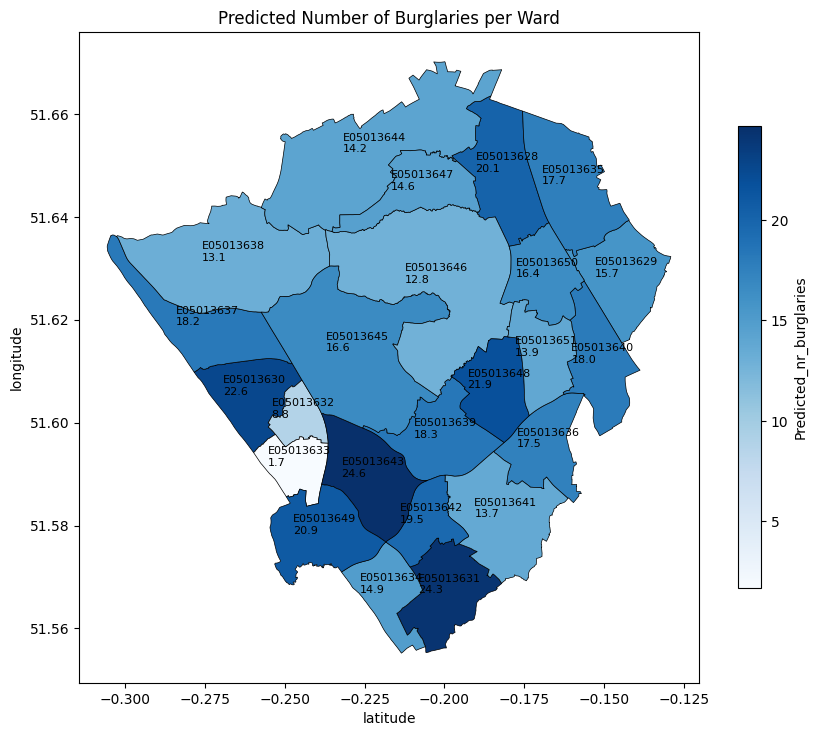

In [25]:
# map with ward bounds
# prepare the data
cpw = predicted_df_ward
# combine all ward geojson files into one
geojson_directory = 'C:/Users/20212324/DC2/metropolitan/barnet_wards_geojson/'  # folder with geojson files per ward in Barnet
gdf_list = []
for filepath in glob.glob(os.path.join(geojson_directory, '*.geojson')):
    gdf = gpd.read_file(filepath)
    filename = os.path.basename(filepath)
    ward_code = os.path.splitext(filename)[0]
    gdf['Ward code'] = ward_code
    gdf_list.append(gdf)
combined_gdf = gpd.GeoDataFrame(pd.concat(gdf_list, ignore_index=True))
merged_cpw_geo = pd.merge(combined_gdf, cpw, on=['Ward code'])
# Convert LineString to Polygon
merged_cpw_geo['geometry'] = merged_cpw_geo['geometry'].apply(lambda x: Polygon(x.coords) if x.geom_type == 'LineString' else x)
# Plot the merged GeoDataFrame with filled polygons
ax = merged_cpw_geo.plot(column='Predicted_nr_burglaries', cmap='Blues', edgecolor='black', linewidth=0.5, figsize=(10, 10))
# for annotations:
for idx, row in merged_cpw_geo.iterrows():
    centroid = row['geometry'].centroid
    ax.annotate( str(row['Ward code']) + "\n" + str(round(row['Predicted_nr_burglaries'], 1)), xy=(centroid.x, centroid.y), xytext=(-20, 0), textcoords="offset points", fontsize=8)
# style the map
ax.set_title('Predicted Number of Burglaries per Ward')
sm = plt.cm.ScalarMappable(cmap='Blues')
sm.set_array(merged_cpw_geo['Predicted_nr_burglaries'])
cbar = plt.colorbar(sm, orientation='vertical', shrink=0.6, ax=ax)
cbar.set_label('Predicted_nr_burglaries')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()

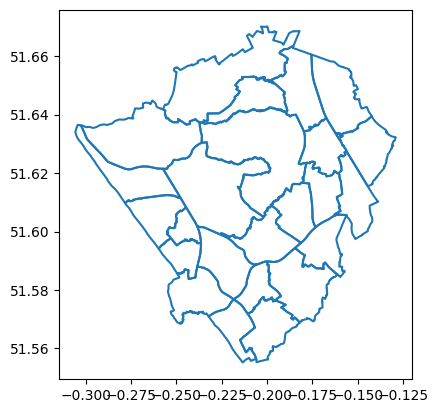

In [26]:
# plain ward boundaries
combined_gdf.plot()
plt.show()

                                              geometry  LSOA code  \
0    POLYGON ((-0.13844 51.63652, -0.13534 51.63512...  E01000115   
1    POLYGON ((-0.14836 51.63712, -0.14759 51.63628...  E01000116   
2    POLYGON ((-0.15362 51.63381, -0.15445 51.63321...  E01000117   
3    POLYGON ((-0.15155 51.63453, -0.14967 51.63363...  E01000118   
4    POLYGON ((-0.13399 51.63405, -0.13395 51.63361...  E01000119   
..                                                 ...        ...   
200  POLYGON ((-0.17462 51.62222, -0.17482 51.62145...  E01000320   
201  POLYGON ((-0.17381 51.62378, -0.17374 51.62305...  E01000321   
202  POLYGON ((-0.17609 51.61923, -0.17609 51.61873...  E01000322   
203  POLYGON ((-0.17189 51.61706, -0.17212 51.61653...  E01000323   
204  POLYGON ((-0.16442 51.61710, -0.16345 51.61643...  E01000324   

     Predicted_nr_burglaries  
0                   1.500000  
1                   1.500000  
2                   2.111111  
3                   1.636364  
4               

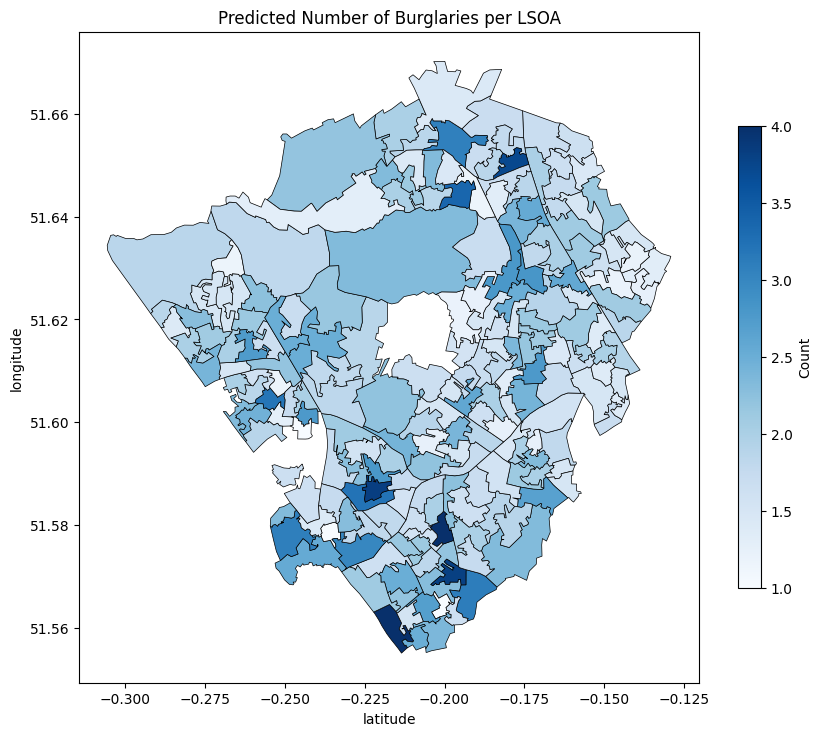

In [27]:
# map with LSOA bounds
# prepare the data
geo_LSOA = gpd.read_file('C:/Users/20212324/DC2/barnet_lsoa.geojson') # LSOA boundaries
geo_LSOA = geo_LSOA[['geometry', 'lsoa11cd']]
geo_LSOA.rename(columns={'lsoa11cd': 'LSOA code'}, inplace=True)
counts_per_LSOA = predicted_df
merged_cpl_geo = pd.merge(geo_LSOA, counts_per_LSOA, on=['LSOA code'])
print(merged_cpl_geo)
# Plot the merged GeoDataFrame with filled polygons
ax = merged_cpl_geo.plot(column='Predicted_nr_burglaries', cmap='Blues', edgecolor='black', linewidth=0.5, figsize=(10, 10))
## for annotations:
#for idx, row in merged_cpl_geo.iterrows():
    #centroid = row['geometry'].centroid
    #ax.annotate( str(row['LSOA code']) + "\n" + str(row['Predicted_nr_burglaries']), xy=(centroid.x, centroid.y), xytext=(-20, 0), textcoords="offset points", fontsize=8)
# style the map
ax.set_title('Predicted Number of Burglaries per LSOA')
sm = plt.cm.ScalarMappable(cmap='Blues')
sm.set_array(merged_cpl_geo['Predicted_nr_burglaries'])
cbar = plt.colorbar(sm, orientation='vertical', shrink=0.6, ax=ax)
cbar.set_label('Count')
plt.xlabel('latitude')
plt.ylabel('longitude')
plt.show()

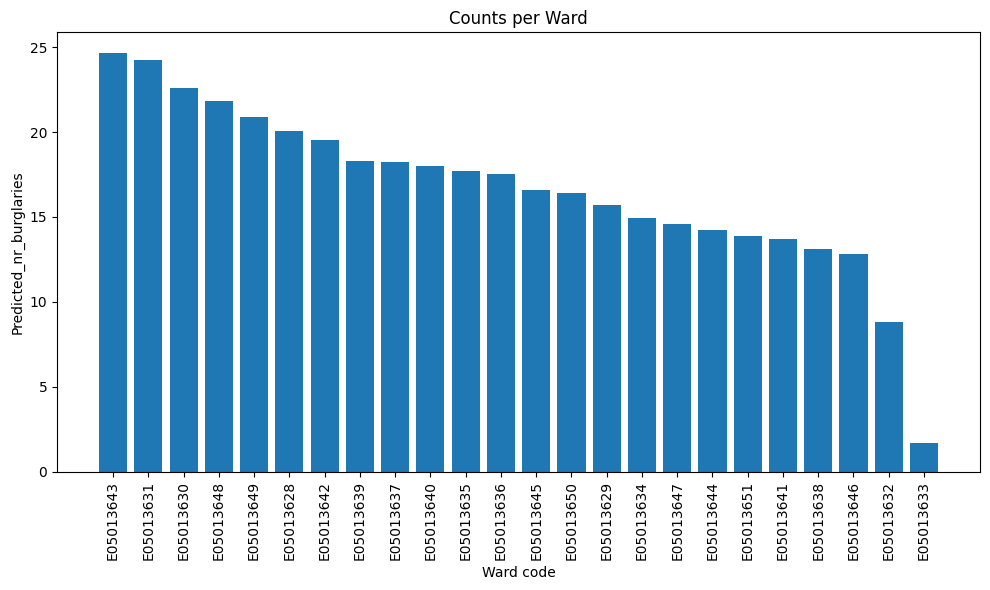

In [28]:
# barplot counts per ward
cpw_sorted = cpw.sort_values(by='Predicted_nr_burglaries', ascending=False)
plt.figure(figsize=(10, 6))
plt.bar(cpw_sorted['Ward code'], cpw_sorted['Predicted_nr_burglaries'])
plt.xticks(rotation='vertical')
plt.xlabel('Ward code')
plt.ylabel('Predicted_nr_burglaries')
plt.title('Counts per Ward')
plt.tight_layout()
plt.show()

In [30]:
# interactive map with LSOA and ward boundaries as different layers
import folium
import webbrowser
import pandas as pd
from branca.colormap import linear

merged_data = merged_cpw_geo
merged_data2 = merged_cpl_geo
count_colormap = linear.YlOrRd_09.scale(merged_data['Predicted_nr_burglaries'].min(), merged_data['Predicted_nr_burglaries'].max())
m = folium.Map(location=[merged_cpw_geo['geometry'][0].centroid.y, merged_cpw_geo['geometry'][0].centroid.x], zoom_start=11)
folium.GeoJson(
    merged_data,
    name='Ward Boundaries',
    style_function=lambda feature: {
        'fillColor': count_colormap(feature['properties']['Predicted_nr_burglaries']),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(fields=['Ward code', 'Predicted_nr_burglaries'], labels=True, sticky=True)
).add_to(m)
folium.GeoJson(
    merged_data2,
    name='LSOA Boundaries',
    style_function=lambda feature: {
        'fillColor': count_colormap(feature['properties']['Predicted_nr_burglaries']),
        'color': 'black',
        'weight': 0.5,
        'fillOpacity': 0.7,
    },
    tooltip=folium.GeoJsonTooltip(fields=['LSOA code', 'Predicted_nr_burglaries'], labels=True, sticky=True)
).add_to(m)
count_colormap.add_to(m)
folium.LayerControl().add_to(m)
map_file = 'interactive_map.html'
m.save(map_file)
webbrowser.open_new_tab(map_file)

True